In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

import cv2
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance



In [3]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = filename.split('.')[0] + '.resaved.jpg'
    ELA_filename = filename.split('.')[0] + '.ela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality=quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im


In [4]:

X = []
Y = []
for i in os.listdir('gdrive/My Drive/Dataset/real'):
    if i.endswith('.jpg'):
        X.append(array(convert_to_ela_image('gdrive/My Drive/Dataset/real/'+i, 90).resize((128, 128))).flatten() / 255.0)
        Y.append(1)

for i in os.listdir('gdrive/My Drive/Dataset/fake'):
    if i.endswith('.jpg'):
        X.append(array(convert_to_ela_image('gdrive/My Drive/Dataset/fake/'+i, 90).resize((128, 128))).flatten() / 255.0)
        Y.append(0)

X = np.array(X)
Y = to_categorical(Y,2)

X = X.reshape(-1,128,128,3)
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.20,random_state=5)


In [5]:
Fake_Detector = Sequential()
Fake_Detector.add(Conv2D(filters = 32,kernel_size = (5,5), padding = 'valid', activation = 'relu', input_shape=(128,128,3)))
Fake_Detector.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'valid', activation = 'relu'))
Fake_Detector.add(MaxPool2D(pool_size=(2,2)))
Fake_Detector.add(Dropout(0.25))
Fake_Detector.add(Flatten())
Fake_Detector.add(Dense(256,activation = "relu"))
Fake_Detector.add(Dropout(0.5))
Fake_Detector.add(Dense(2,activation = "softmax"))
Fake_Detector.summary()

optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
Fake_Detector.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_acc',min_delta=0, patience=2, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               29491456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [6]:
epochs = 30
batch_size = 100
history= Fake_Detector.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2, callbacks=[early_stopping])

Epoch 1/30
33/33 - 293s - loss: 0.7237 - accuracy: 0.5348 - val_loss: 0.6823 - val_accuracy: 0.5753
Epoch 2/30
33/33 - 291s - loss: 0.6841 - accuracy: 0.5721 - val_loss: 0.6683 - val_accuracy: 0.5949
Epoch 3/30
33/33 - 291s - loss: 0.6581 - accuracy: 0.6141 - val_loss: 0.6613 - val_accuracy: 0.6120
Epoch 4/30
33/33 - 290s - loss: 0.6242 - accuracy: 0.6606 - val_loss: 0.6546 - val_accuracy: 0.6120
Epoch 5/30
33/33 - 292s - loss: 0.5903 - accuracy: 0.6916 - val_loss: 0.6581 - val_accuracy: 0.6047
Epoch 6/30
33/33 - 290s - loss: 0.5297 - accuracy: 0.7391 - val_loss: 0.7650 - val_accuracy: 0.5704
Epoch 7/30
33/33 - 292s - loss: 0.4670 - accuracy: 0.7761 - val_loss: 0.8451 - val_accuracy: 0.5863
Epoch 8/30
33/33 - 292s - loss: 0.4010 - accuracy: 0.8156 - val_loss: 0.6833 - val_accuracy: 0.5998
Epoch 9/30
33/33 - 294s - loss: 0.3753 - accuracy: 0.8447 - val_loss: 0.9212 - val_accuracy: 0.5716
Epoch 10/30
33/33 - 295s - loss: 0.2869 - accuracy: 0.8842 - val_loss: 1.0960 - val_accuracy: 0.5741

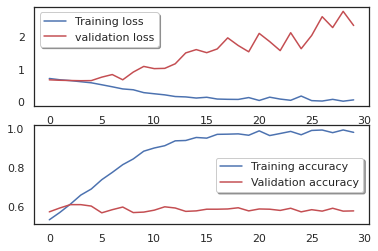

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

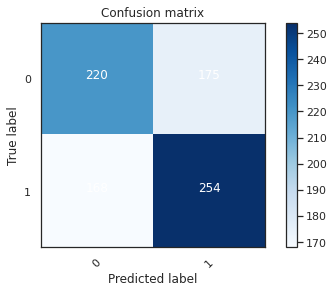

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

Y_pred = Fake_Detector.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [9]:
Fake_Detector.save('deepfake-detection-model.h5')

In [21]:
from tensorflow.keras.models import load_model
model = load_model('deepfake-detection-model.h5')
temp = array(convert_to_ela_image('real_00001.jpg', 90).resize((128, 128))).flatten() / 255.0
temp = np.array(temp)
temp = temp.reshape(-1,128,128,3)
if model.predict_classes(temp) == [0]:
  print("Fake Image")
else:
  print("Real Image")

Real Image
